In [2]:
# Pre-processing
from google.colab import drive
drive.mount('/content/drive')
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Mounted at /content/drive


In [3]:
def obj_fun(x : tuple, *args):
  mu, E = x
  u, n, exp_num, d, rho, D = args

  test_damper = damper(d, D, mu, E, rho, n, exp = exp_num)

  # have to match sim to test so that least_squares has 1:1 data matchup
  test_damper.match_test(u)

  return test_damper.least_squares()

def optimize(*args): # u in mm/s
  import numpy as np
  from scipy.optimize import minimize
  x0 = (700, 100) # realistic starting point
  res = minimize(obj_fun, x0, method='nelder-mead', \
                args = (args), options={'disp': False})
  return res.x

/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:60: RuntimeWarning: invalid value encountered in double_scalars
  A_Cd = (19000*self.beta/self.ReD)**0.8
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:67: RuntimeWarning: invalid value encountered in double_scalars
  + 0.000521*(10**6*self.beta/self.ReD)**0.7 \
/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py:68: RuntimeWarning: invalid value encountered in double_scalars
  + (0.0188 + 0.0063*A_Cd)*self.beta**(3.5)*(10**6/self.ReD)**0.3 \


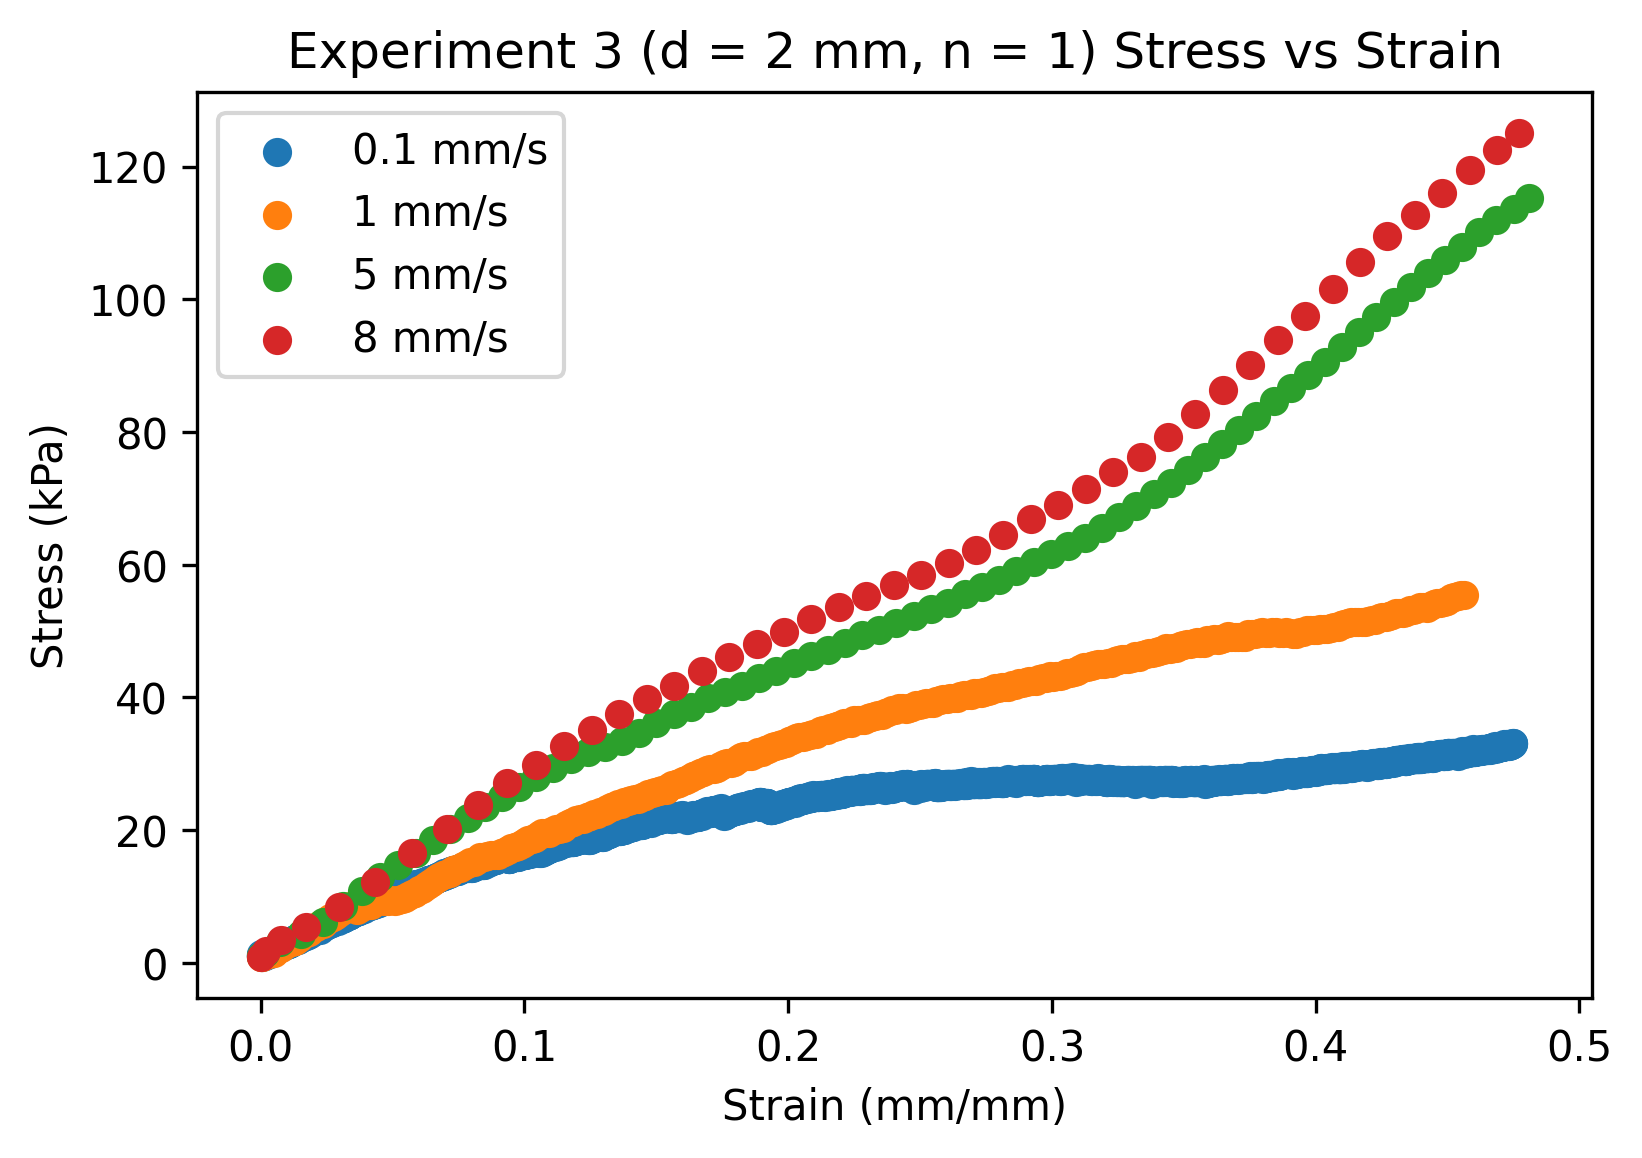

In [4]:
# Experiment 3
import numpy as np

test_speeds = [0.1, 1, 5, 8] # mm/s

vals = np.zeros((len(test_speeds), 2))

for i in range(len(test_speeds)):
  n = 1
  exp_num = 3
  d = 2E-3 # m
  rho = 1300 # kg/m^3 (toothpaste)
  D = (20 + 23.5)/2 * 1E-3 # m
  u = test_speeds[i] # mm/s
  vals[i,:] = optimize(u, n, exp_num, d, rho, D)

d = 2E-3 # m
D = (20 + 23.5)/2 * 1E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
n = 1

dampers = []

for i in range(len(test_speeds)):
  mu, E = vals[i, 0], vals[i, 1]
  dampers.append(damper(d, D, mu, E, rho, n, exp = 3))
  u = test_speeds[i] # m/s
  dampers[i].match_test(u)
  plt.scatter(dampers[i].test_strain, dampers[i].test_stress, label = "{} mm/s".format(u))
plt.title("Experiment 3 (d = 2 mm, n = 1) Stress vs Strain")
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (kPa)")
plt.legend()
plt.show()

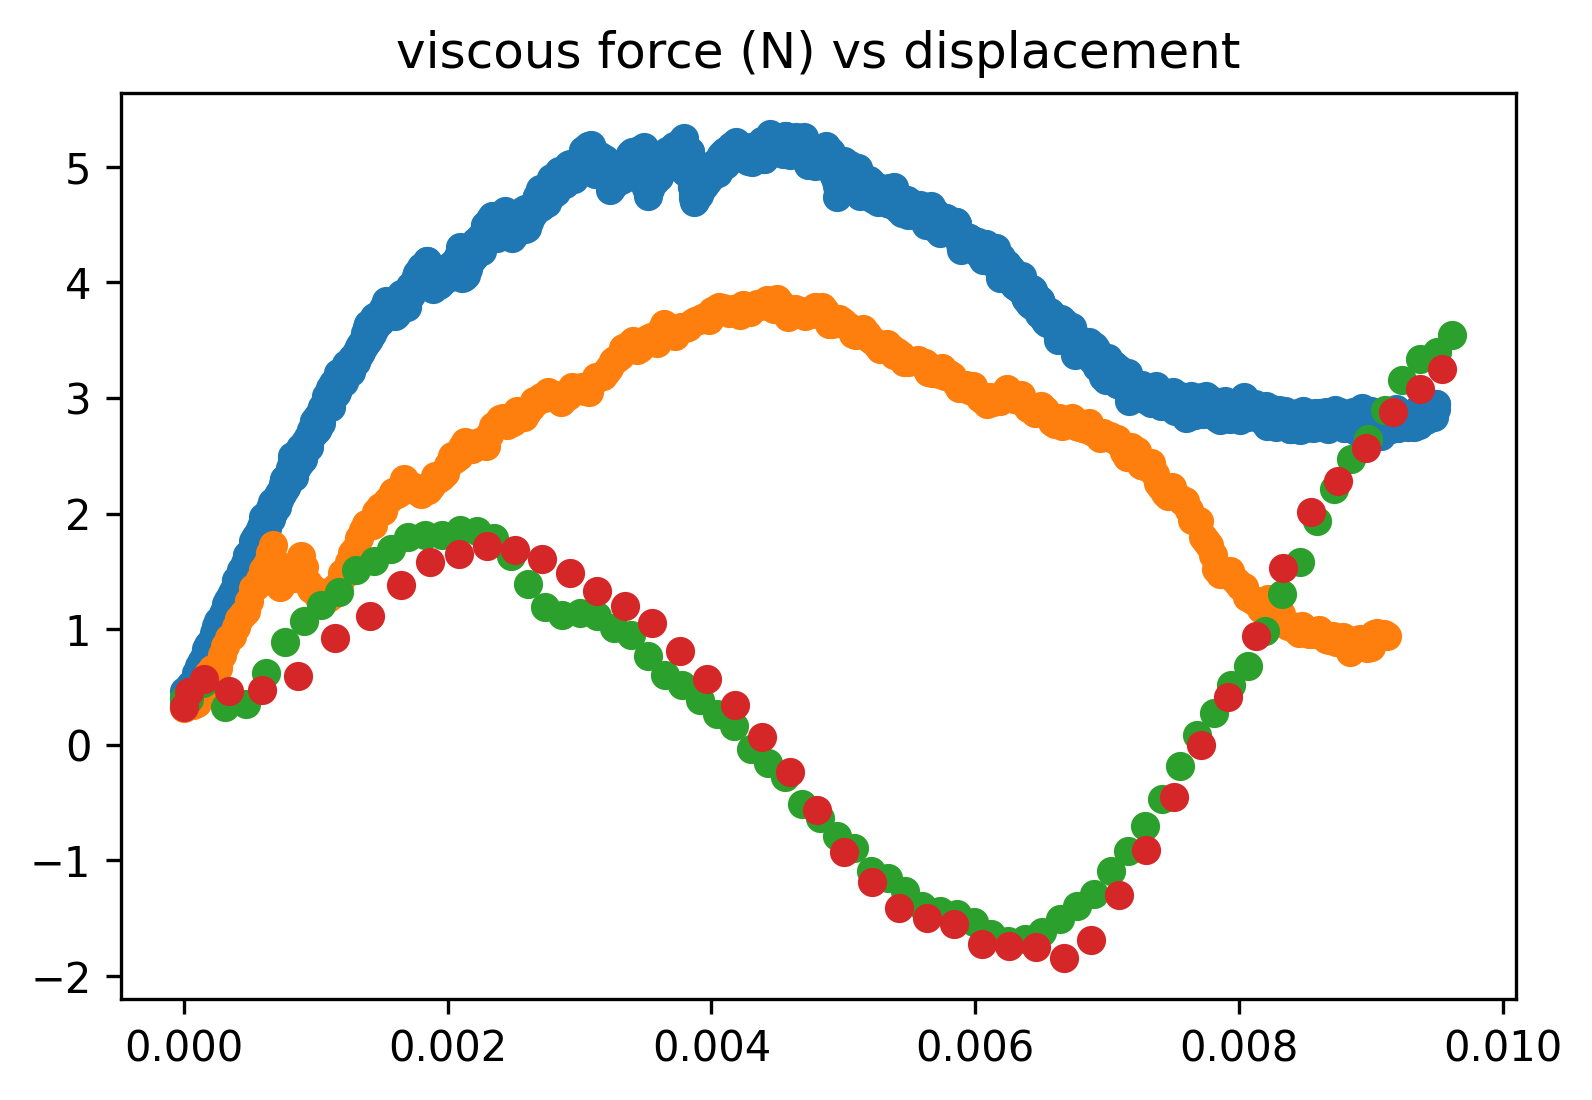

In [5]:
# Exp 3 mus
test_mus = []
for i in range(len(test_speeds)):
  total_force = np.array(dampers[i].test_force)
  spring_force = np.array(dampers[i].test_disp)*dampers[i].k
  disp = np.array(dampers[i].test_disp)
  plt.scatter(disp, total_force - spring_force)
  viscous_force = (np.average(total_force - spring_force)) # N
  mu = viscous_force*np.pi*(dampers[i].d/2)**4/(8*dampers[i].t*dampers[i].Q*dampers[i].a) # kg/(m-s)
  test_mus.append(mu)
plt.title('viscous force (N) vs displacement')
plt.show()

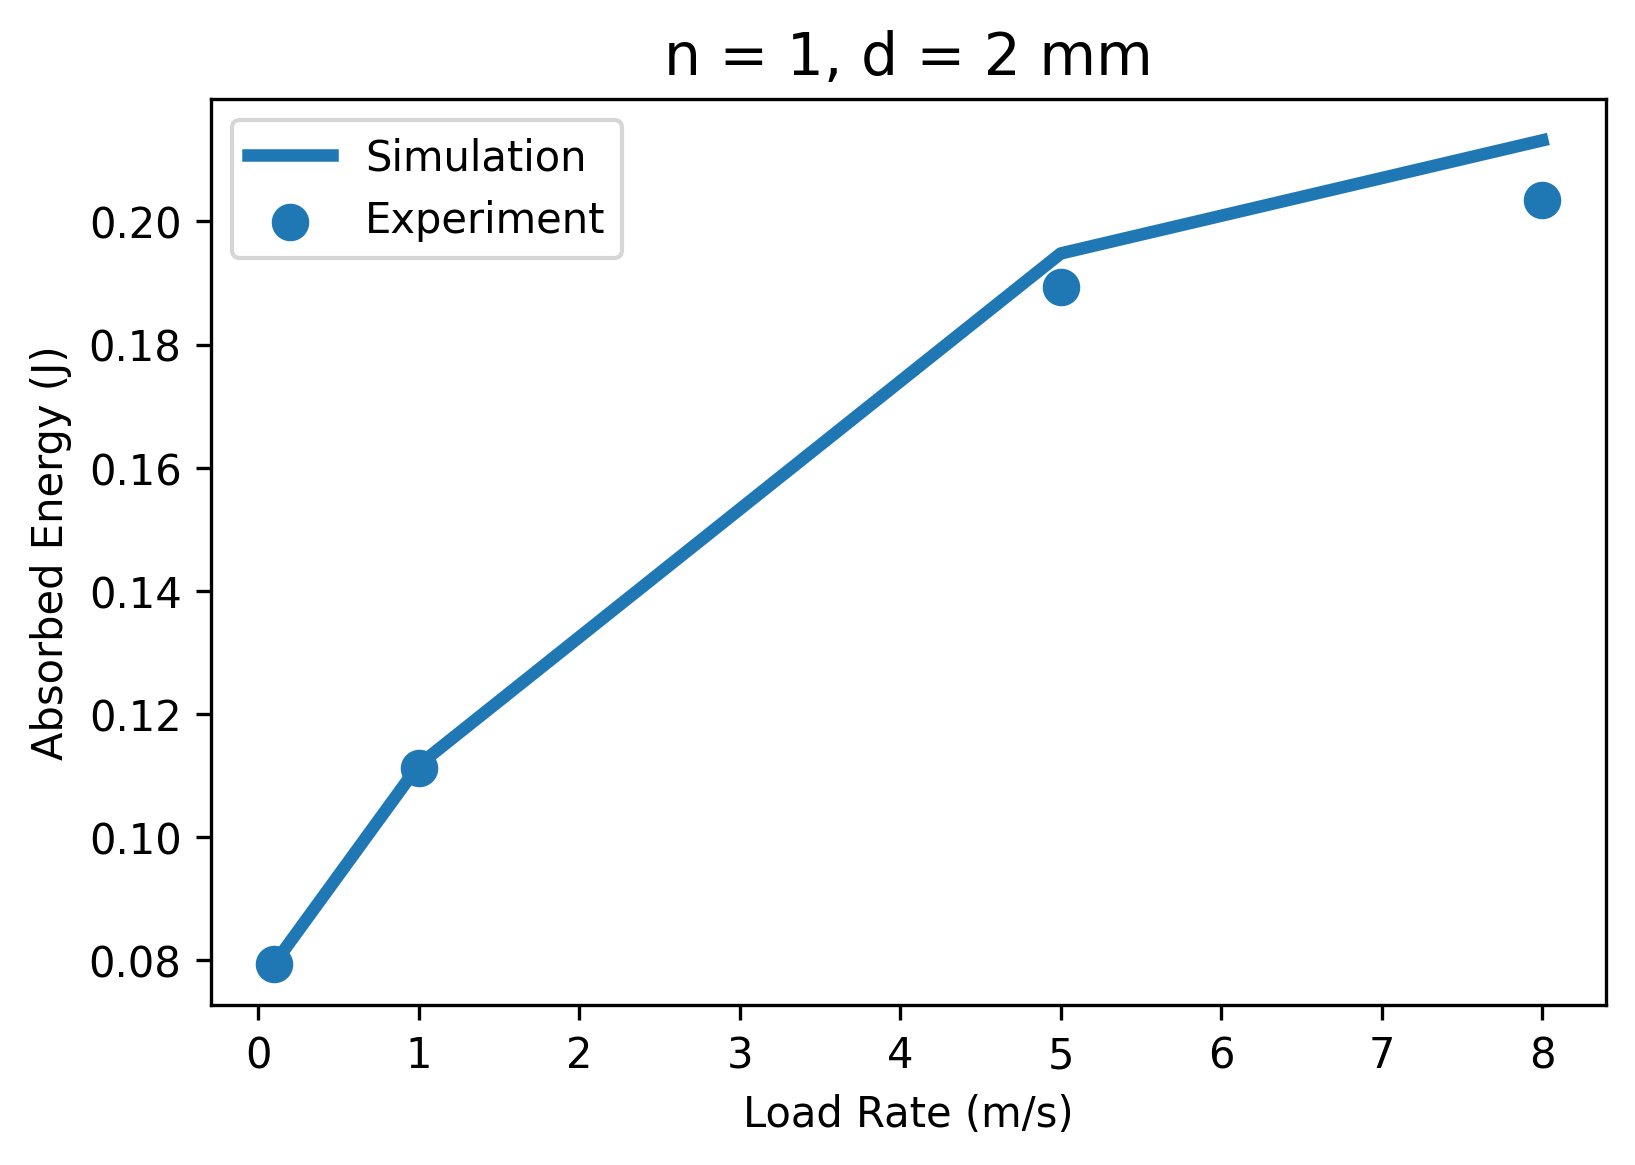

In [6]:
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"

energies = []

sim_energies = []
exp_energies = []
for damper in dampers:
  sim_energies.append(damper.energy)
  exp_energies.append(damper.left_point_integrate(\
                      damper.test_disp, damper.test_force))

plt.plot(test_speeds, sim_energies, linewidth = 3, label = "Simulation")
plt.scatter(test_speeds, exp_energies, linewidth = 3, label = "Experiment")
plt.title("n = 1, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (m/s)")
plt.ylabel("Absorbed Energy (J)")
plt.legend()
plt.show()

sim_energies3 = sim_energies
exp_energies3 = exp_energies

<ipython-input-7-3e564d5e46a8>:14: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c


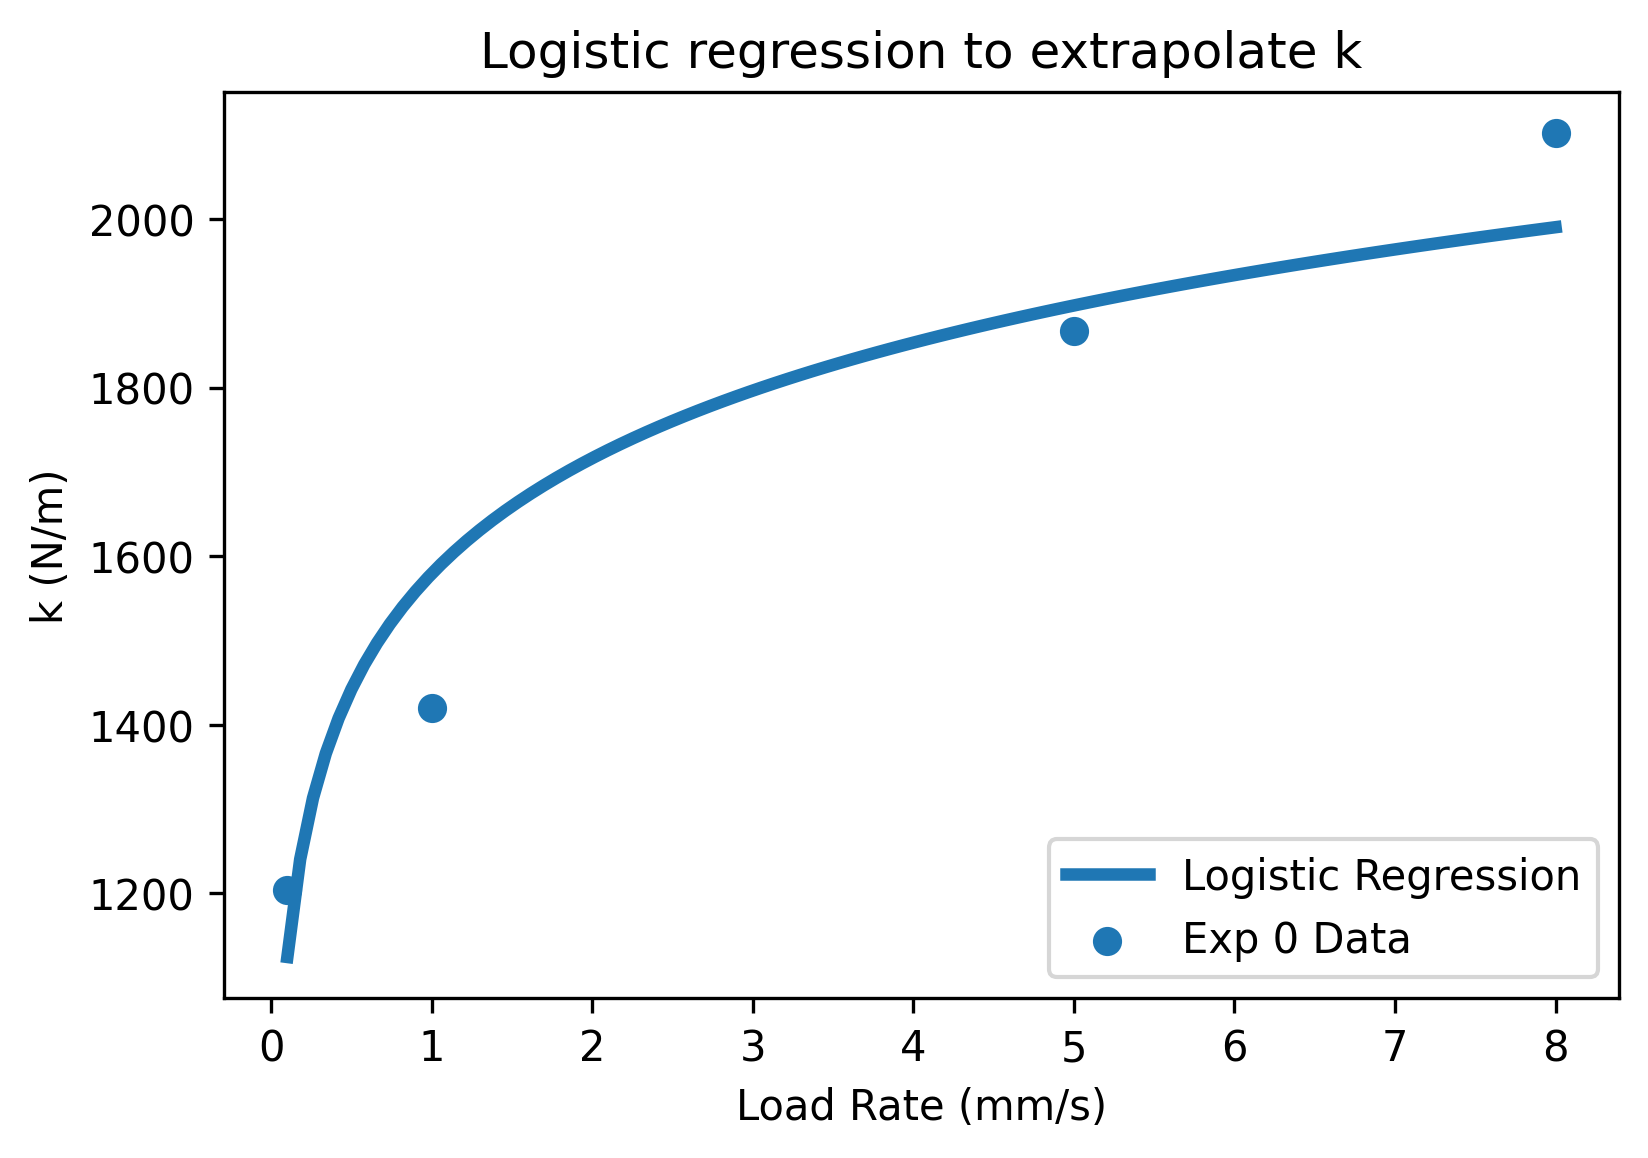

r-squared for k: 0.9101387858160587
k at 8 m/s: 3354.818465228649 N/m


<ipython-input-7-3e564d5e46a8>:37: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)+c


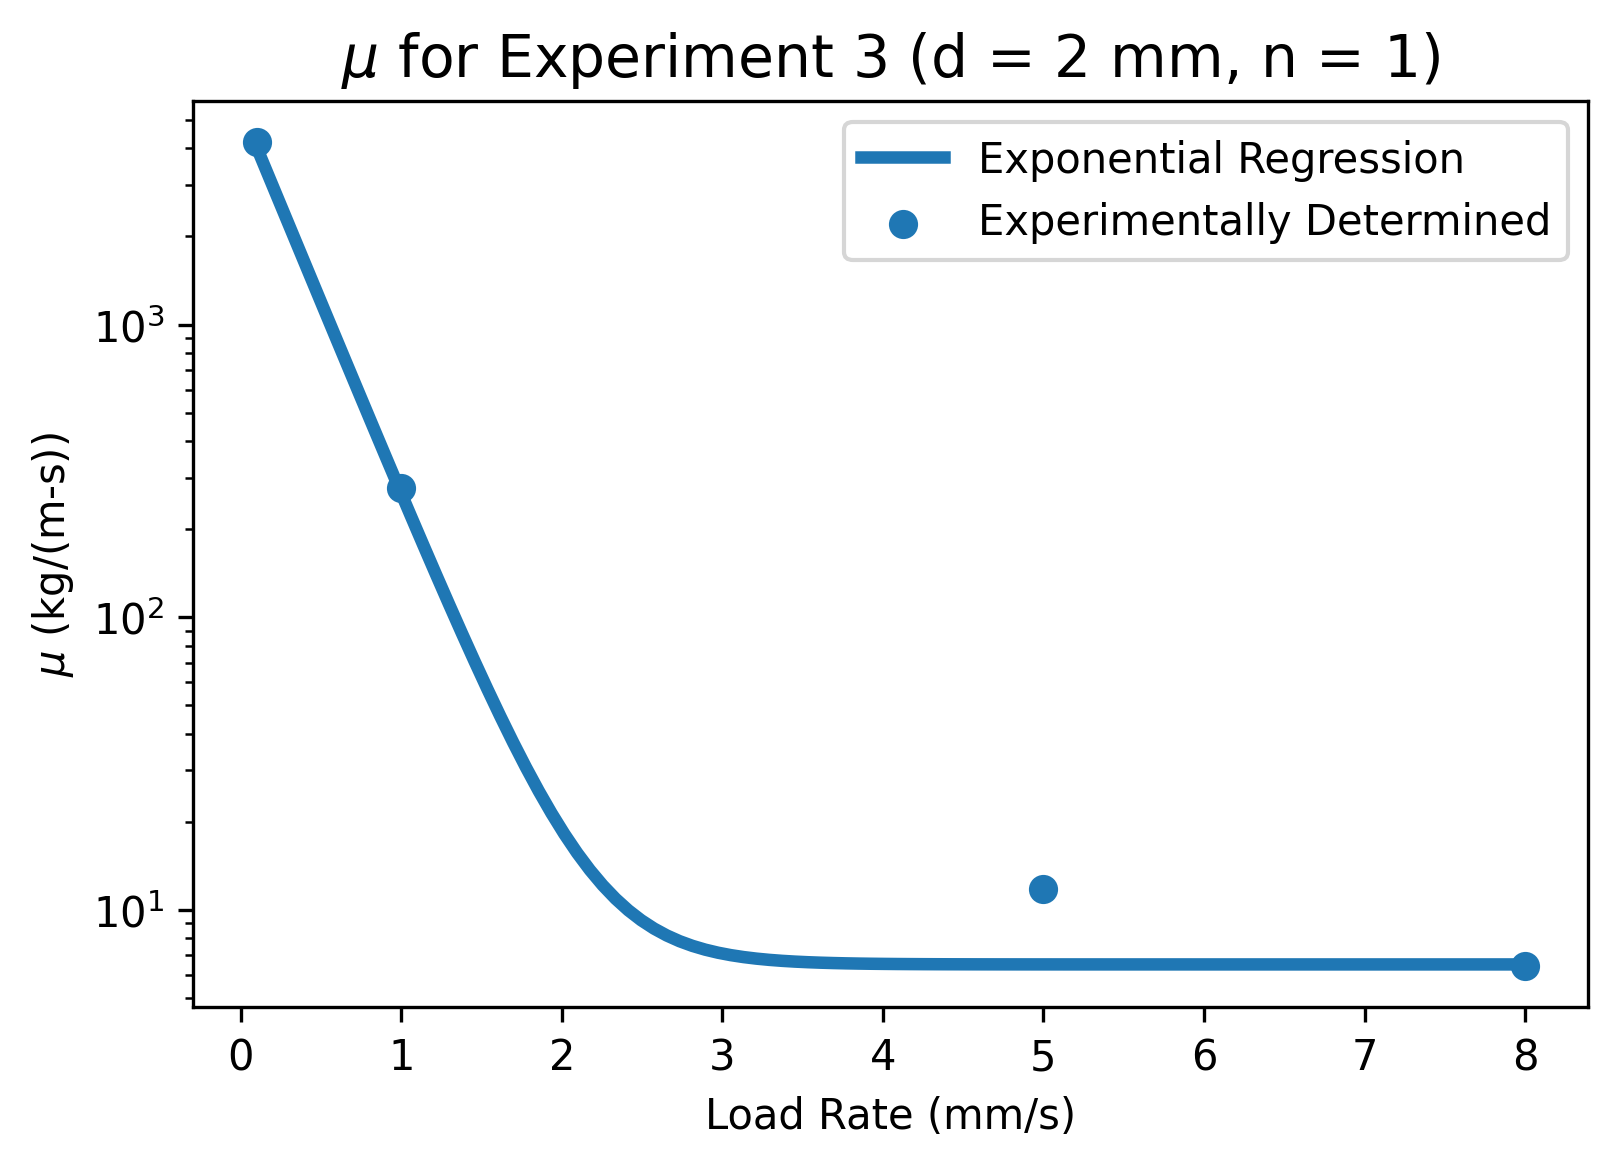

r-squared for mu: 0.9976218048591736
mu at 8 m/s: 6.513470108970588 kg/(m-s)


<ipython-input-7-3e564d5e46a8>:58: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c
/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


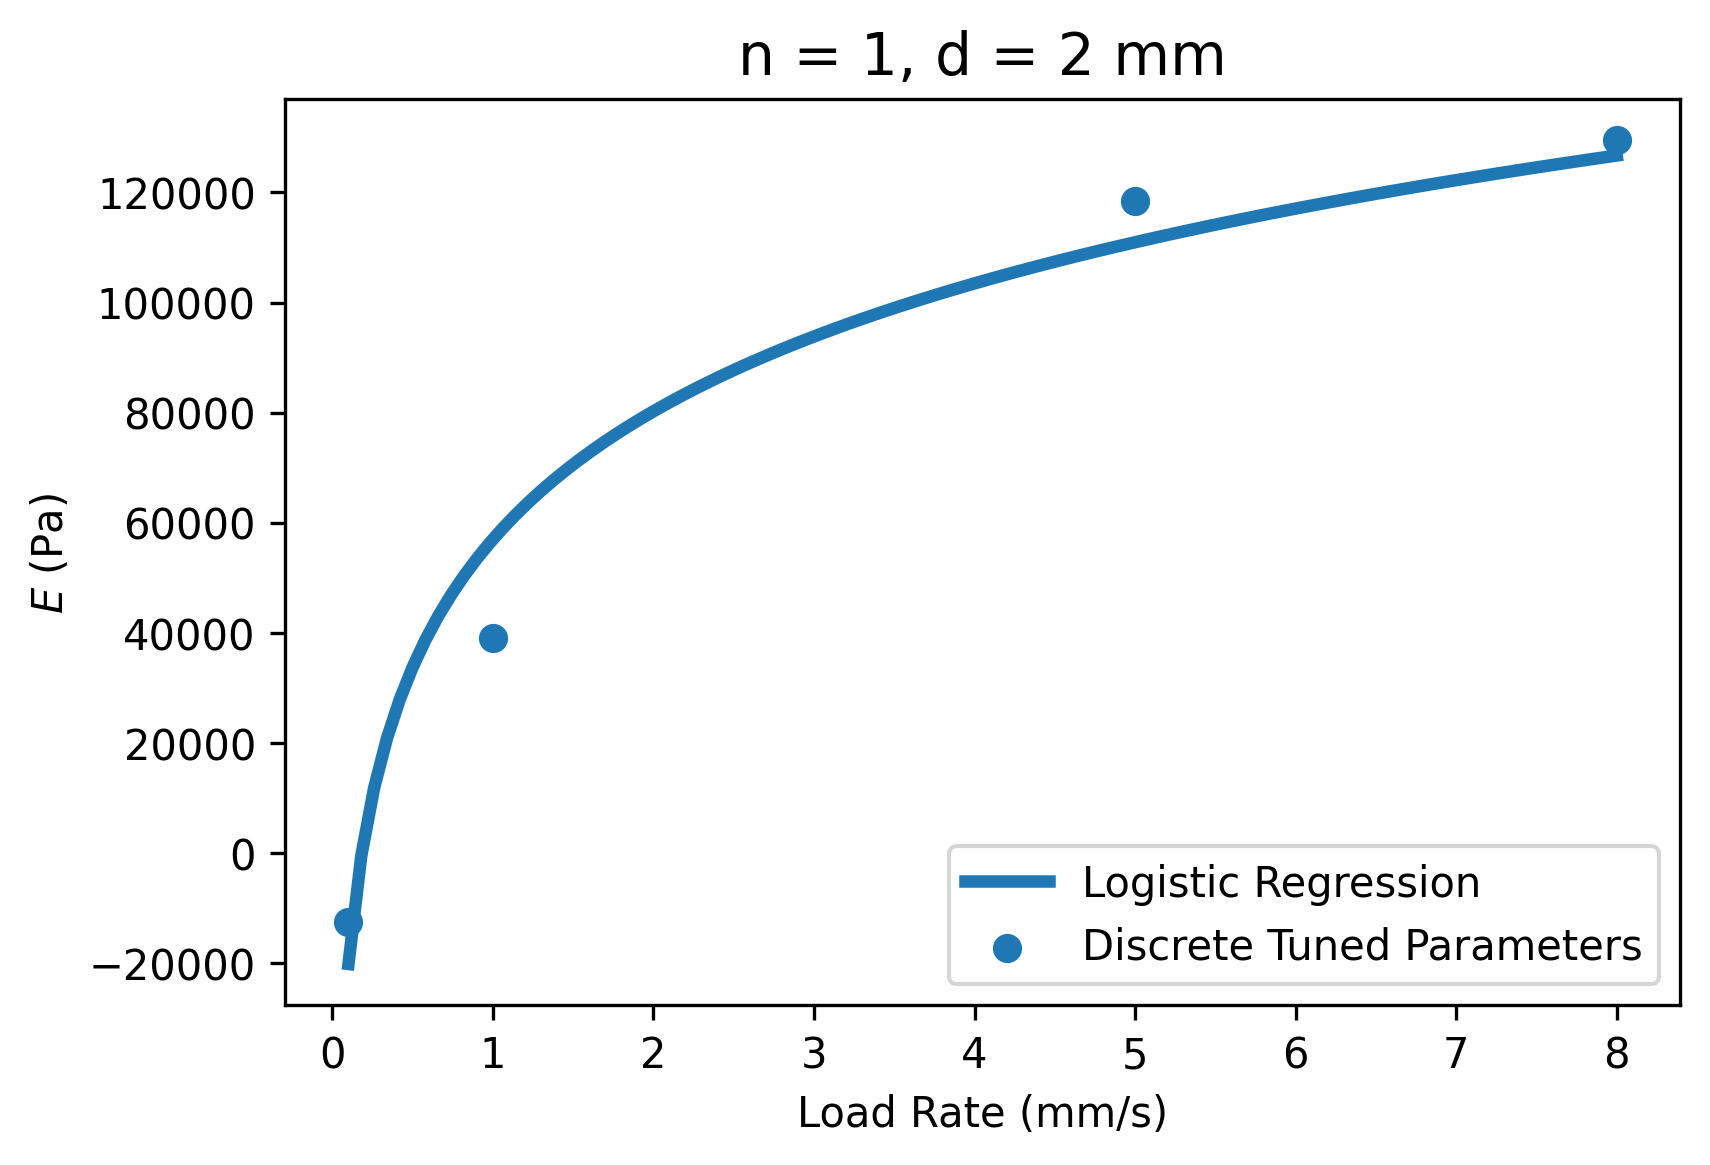

r-squared for E: 0.9673411712447552
E at 8 m/s: 358.31120176314477 kPa


In [7]:
''' Fitting tuned parameters with regression and plotting experimentally determined mu'''

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# plot k vs speed (k only needs to be worked with for this prototype for market comparison)
k_dict = {0.1E-3:1.20372919E3, 1E-3:1.41932069E3, 5E-3:1.86683541E3, 8E-3:2.10151015E3} # N/m
plt.scatter(np.array([*k_dict.keys()])*1E3, k_dict.values(), label = 'Exp 0 Data')
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("k (N/m)")

# logistic growth fit to k
def func(x, a, b, c):
    return a*np.log(b*x)+c

params, _ = curve_fit(func, np.array([*k_dict.keys()])*1E3, np.array([*k_dict.values()]))
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.log(x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Logistic Regression')
plt.legend(loc = 4)
plt.title('Logistic regression to extrapolate k')
plt.show()
print('r-squared for k: {}'.format(r2_score(np.array([*k_dict.values()]), yfit(np.array([*k_dict.keys()])*1E3))))
print('k at 8 m/s: {} N/m'.format(yfit(8000)))
k_8000 = yfit(8000)

# plot mu (experimental) vs speed
plt.yscale("log")
plt.scatter(test_speeds, test_mus, label = 'Experimentally Determined')
plt.title("$\mu$ for Experiment 3 (d = 2 mm, n = 1)", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$\mu$ (kg/(m-s))")

# exp decay fit to mu
def func(x, a, b, c):
    return a*np.exp(-b*x)+c 

params, _ = curve_fit(func, test_speeds, vals[:,0])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.exp(-x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Exponential Regression')
plt.legend()
plt.show()
print('r-squared for mu: {}'.format(r2_score(test_mus, a*np.exp(np.array(test_speeds)*-b)+c)))
print('mu at 8 m/s: {} kg/(m-s)'.format(yfit(8000)))
mu_8000 = yfit(8000)

# plot E vs speed
plt.scatter(test_speeds, vals[:,1], label = 'Discrete Tuned Parameters')
plt.title("n = 1, d = 2 mm", fontsize = 14)
plt.xlabel("Load Rate (mm/s)")
plt.ylabel("$E$ (Pa)")

# logistic growth fit to E
def func(x, a, b, c):
    return a*np.log(b*x)+c

params, _ = curve_fit(func, test_speeds, vals[:,1])
a, b, c = params[0], params[1], params[2]
x_sample = np.linspace(0.1, 8, 100)
yfit = lambda x: a*np.log(x*b)+c
plt.plot(x_sample, yfit(x_sample), linewidth = 3, label = 'Logistic Regression')
plt.legend(loc = 4)
plt.show()
print('r-squared for E: {}'.format(r2_score(vals[:,1], a*np.log(np.array(test_speeds)*b)+c)))
print('E at 8 m/s: {} kPa'.format(yfit(8000)*1E-3))
E_8000 = yfit(8000)*1E-3

Absorbed energy at 8000 mm/s: 6.3158289576020294 MJ


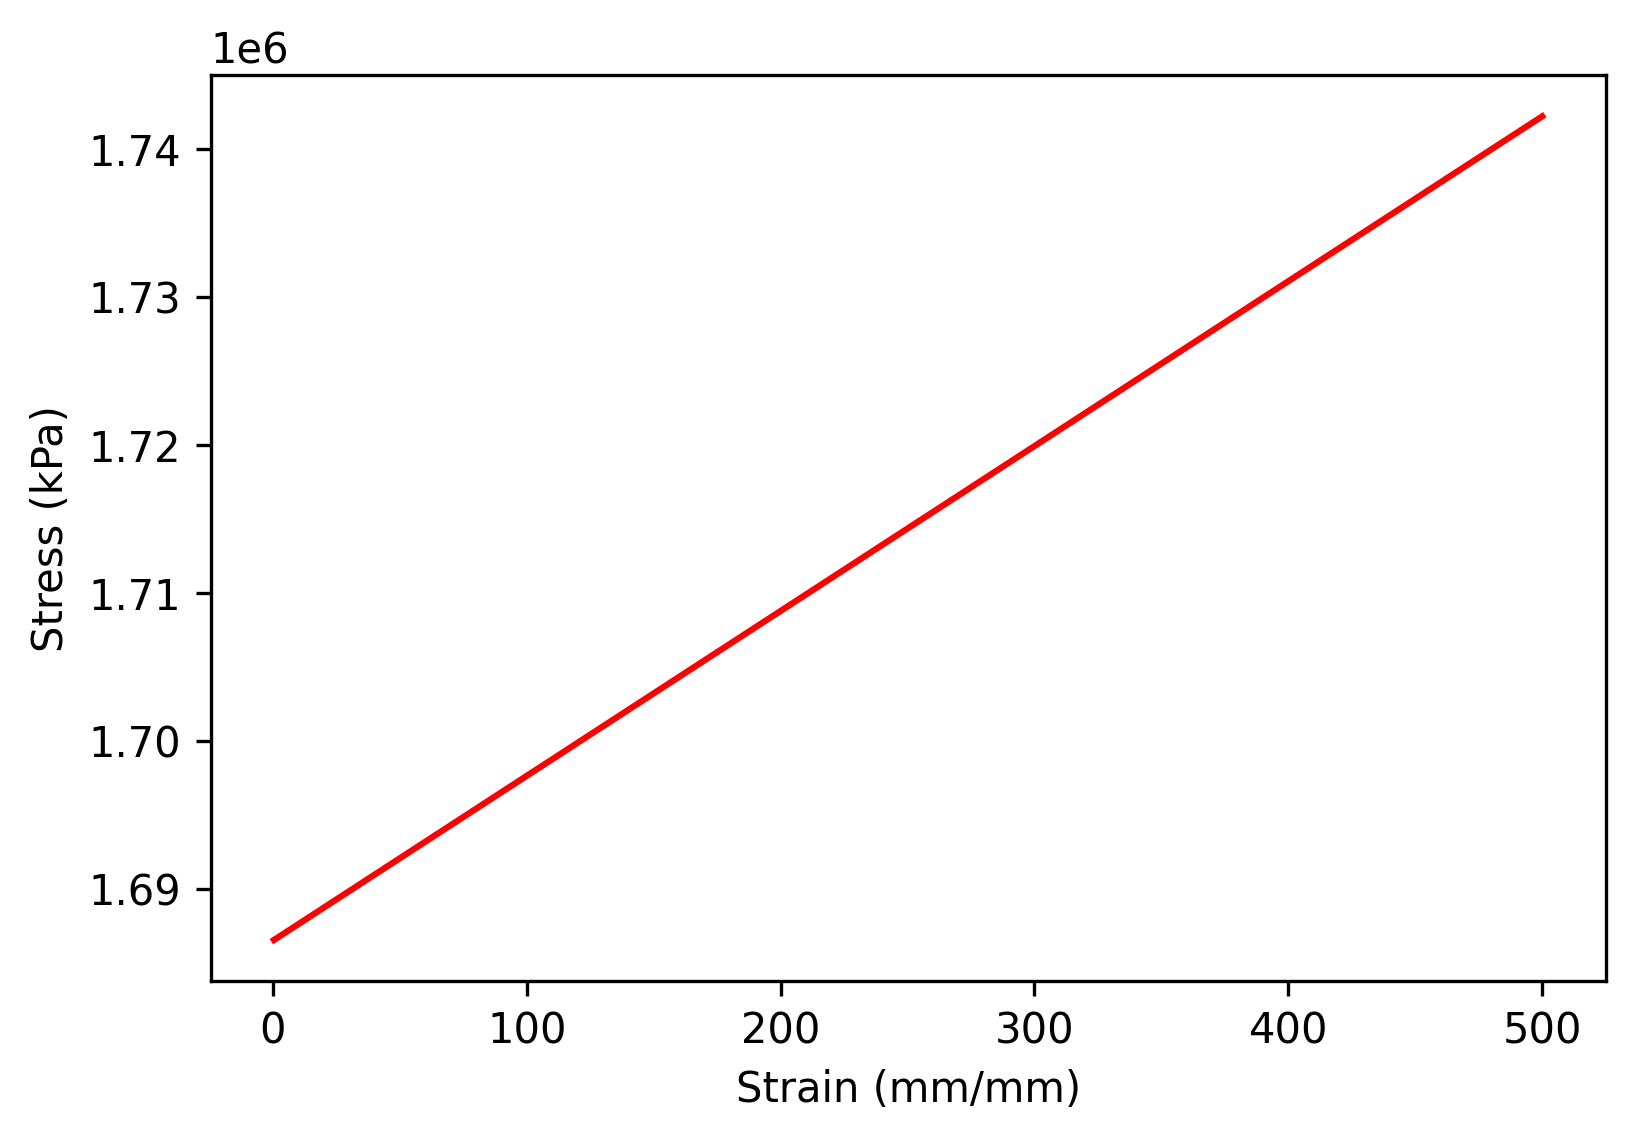

In [8]:
# Using resulting k, mu, and E at 8 m/s to find stress-strain and energy absorbed at 8 m/s load rate
%run "/content/drive/MyDrive/ME 470 Work/Computational Model/damper.py"
import numpy as np

n = 1
d = 2E-3 # m
rho = 1300 # kg/m^3 (toothpaste)
D = (20 + 23.5)/2 * 1E-3 # m
u = 8 # m/s
test_damper = damper(d, D, mu_8000, E_8000, rho, n)

stroke_length = 10 # mm
dt = 0.001 # s
t_total = stroke_length/u # s
n_iterations = int(t_total/dt)
for i in range(n_iterations):
  test_damper.step(u, dt)
test_damper.plotSS()
print('Absorbed energy at 8000 mm/s: {} MJ'.format(test_damper.energy*1E-6))